In [35]:

import sys
import numpy as np
import matplotlib.pyplot as plt #dumped imageio and tifffile packages and used matplotlib to read TIFF files
import pandas as pd
import scipy.signal as signal

from lmfit import models #this is being mixed up with AstroPy's models package below. Change it.
import math
import random
#from lmfit.models import GaussianModel, SkewedGaussianModel, LorentzianModel, VoigtModel

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


In [36]:
class Image:
    
    def __init__(self, image):
        self.raw = image
        self.shape= image.shape
        self.x_size= image.shape[0]
        self.y_size= image.shape[1]
        self.subtracted_data= np.array([[0 for y in range(self.y_size)] for x in range(self.x_size)])
        self.profile_x= [0 in range (self.x_size)]
        self.profile_y= [0 in range (self.y_size)]
        
    def subtract_bg(self,bg):
        if (bg.shape == self.shape): 
            for i in range(self.x_size):
                for j in range (self.y_size):
                    if ((self.raw[i][j]>bg[i][j]).all() and (bg[i][j]>=0).all() and (self.raw[i][j]>=0).all()):
                            self.subtracted_data[i][j]= self.raw[i][j]-bg[i][j]
            return self.subtracted_data
                    #else:
                     #   print("Error when subtracting")
        else:
            print("Error: Background image size does not match data size.")
    
    def get_profile(self):
        #PROFILE IN Y
        for i in range(self.y_size): #loop over all y
            sum=0
            for j in range(self.x_size): #loop over all x for each y: gives one number
                sum=sum+self.subtracted_data[j][i]
            self.profile_y.append(sum)
     
        #PROFILE IN X
        for i in range(self.x_size): #loop over all x
            sum=0
            for j in range(self.y_size): #loop over all y for each x: gives one number
                sum=sum+self.subtracted_data[i][j]
            self.profile_x.append(sum)

In [37]:
##Can I import based on date and viewer from image details?
im=[0 for i in range(0,20)]
i=0
for j in range (15,35):
    im[i]=plt.imread('tiff_files/Tune1'+str(j)+'_07722018_viewer_D1542_001.tiff')
    i+=1

bg=plt.imread('tiff_files/Tune114_background_003.tiff') #background image


In [38]:
im[0]=plt.imread('tiff_files/071918_D1542_overnight_nominal__294.tiff')
bg=plt.imread('tiff_files/071918_D1542_overnight_nominal__295.tiff')


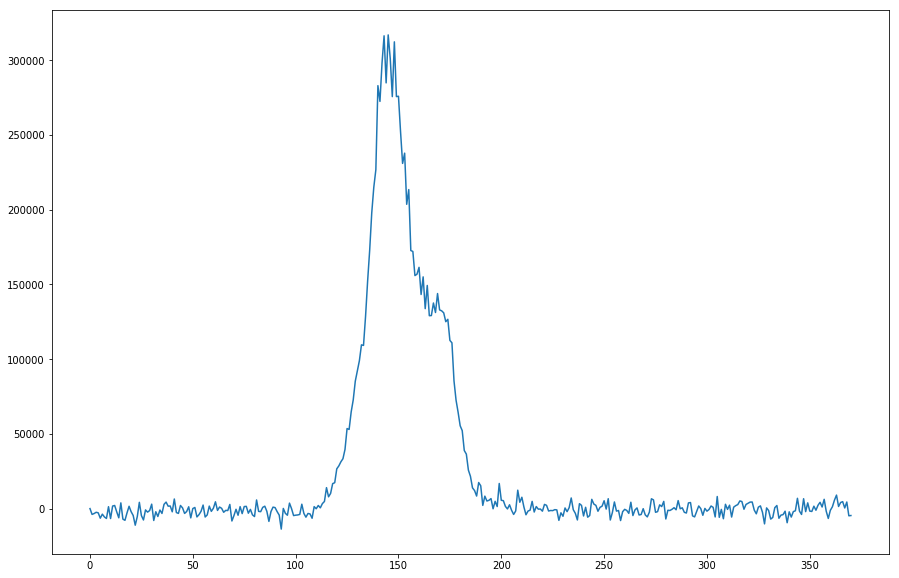

In [39]:
image1=Image(im[0])
##print(image1.subtracted_data)
image1.subtract_bg(bg)
#len(image1.profile_x)
image1.get_profile()
x1 = np.arange(image1.y_size)
x = np.arange(image1.x_size)

#image1.profile_x
profy=np.array(image1.profile_y[1:]-image1.profile_y[1]) #280:330
prof=np.array(image1.profile_x[1:]-image1.profile_x[1]) 

plt.plot(prof)
plt.show()

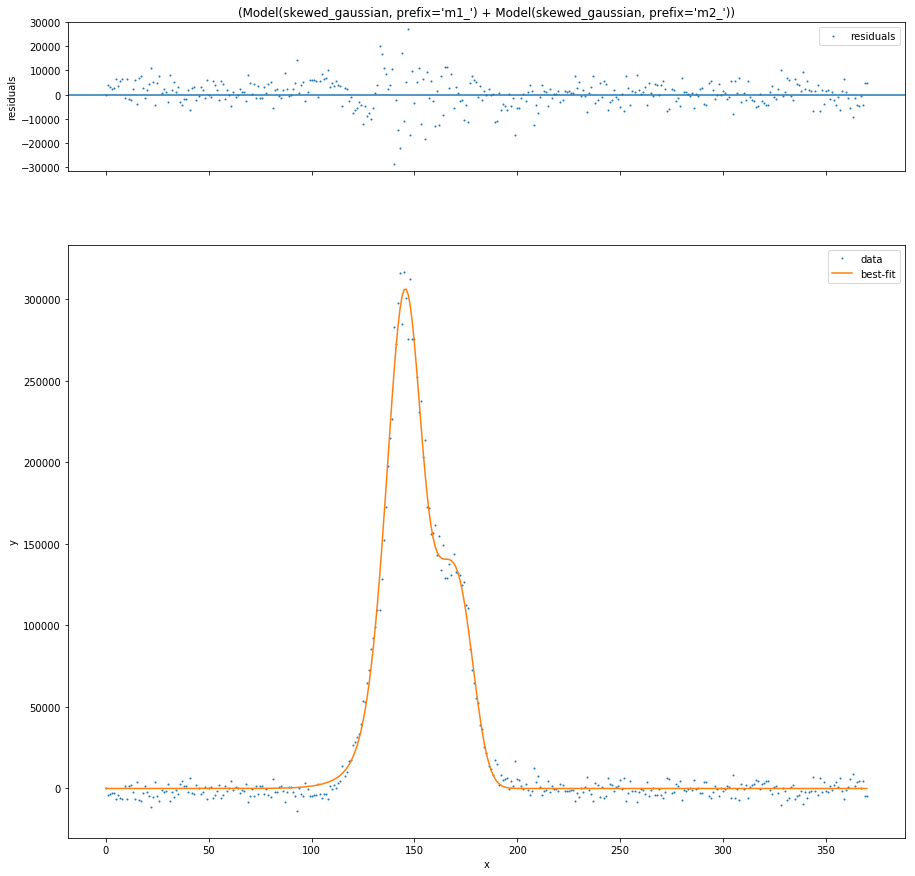

[[Model]]
    (Model(skewed_gaussian, prefix='m1_') + Model(skewed_gaussian, prefix='m2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 343
    # data points      = 371
    # variables        = 8
    chi-square         = 1.2416e+10
    reduced chi-square = 34205218.2
    Akaike info crit   = 6443.97922
    Bayesian info crit = 6475.30884
[[Variables]]
    m1_gamma:     -1.46406490 +/- 0.15919380 (10.87%) (init = 0)
    m1_sigma:      10.9580972 +/- 0.42908326 (3.92%) (init = 1)
    m1_center:     150.589516 +/- 0.34154087 (0.23%) (init = 145)
    m1_amplitude:  4803262.65 +/- 147071.878 (3.06%) (init = 250000)
    m1_height:     174868.374 +/- 5219.75822 (2.98%) == '0.3989423*m1_amplitude/max(1.e-15, m1_sigma)'
    m1_fwhm:       25.8043465 +/- 1.01041060 (3.92%) == '2.3548200*m1_sigma'
    m2_gamma:     -4.01081452 +/- 0.34715234 (8.66%) (init = 0)
    m2_sigma:      25.5591239 +/- 1.11166063 (4.35%) (init = 1)
    m2_center:     178.089995 +/- 0.30707

In [40]:
gauss1 = models.SkewedGaussianModel(prefix='m1_') #SkewedGaussianModel(prefix='g1_')
gauss2= models.SkewedGaussianModel(prefix='m2_')

mod= gauss1 + gauss2 

    
params_1 = gauss1.make_params(amplitude=250000,center=145, sigma=1)
params_2 = gauss2.make_params(amplitude=100000, center=170, sigma=1)
params = params_1.update(params_2)
    


output = mod.fit(prof, params_1, x=x)
fig, gridspec = output.plot(data_kws={'markersize': 1})

#out  = mod.fit(prof, param#s, x=x, weights=np.sqrt(1.0/prof.size))

plt.show()
print(output.fit_report())

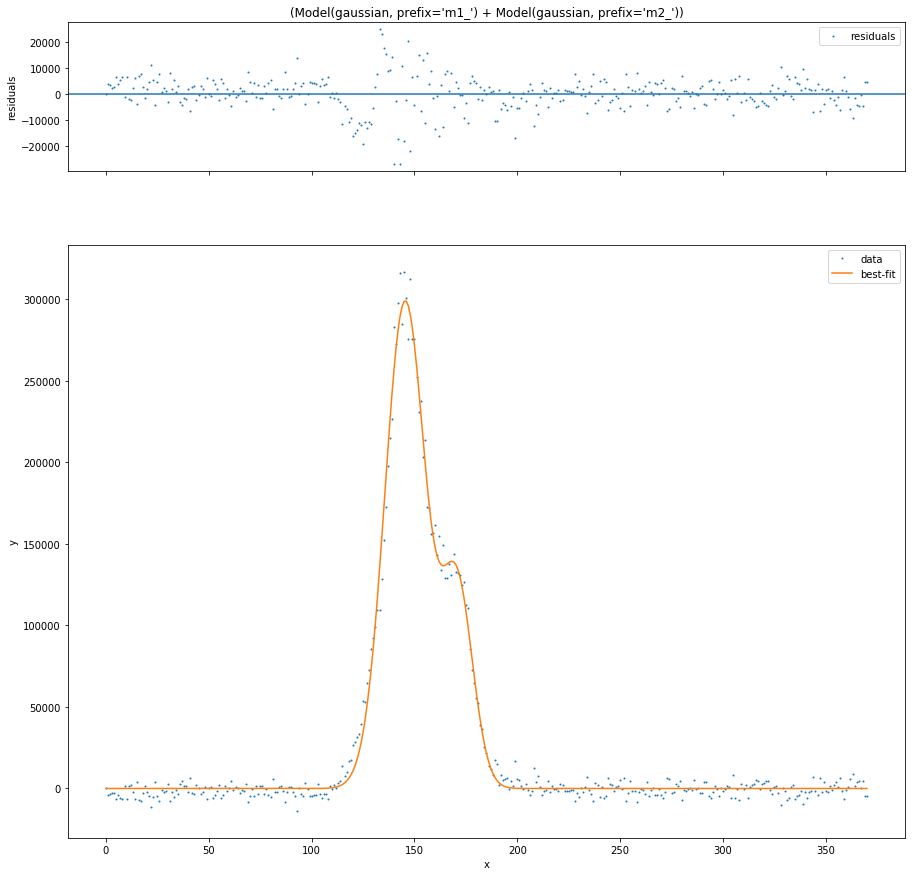

In [41]:
gauss1 = models.GaussianModel(prefix='m1_') #SkewedGaussianModel(prefix='g1_')
gauss2= models.GaussianModel(prefix='m2_')

mod= gauss1 + gauss2 

    
params_1 = gauss1.make_params(amplitude=250000,center=145, sigma=1)
#params_2 = gauss2.make_params(amplitude=100000, center=170, sigma=1)
params = params_1.update(params_2)
    

output = mod.fit(prof, params_1, x=x)
fig, gridspec = output.plot(data_kws={'markersize': 1})

#out  = mod.fit(prof, param#s, x=x, weights=np.sqrt(1.0/prof.size))

plt.show()

In [42]:
def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            # default guess is horrible!! do not use guess()
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params

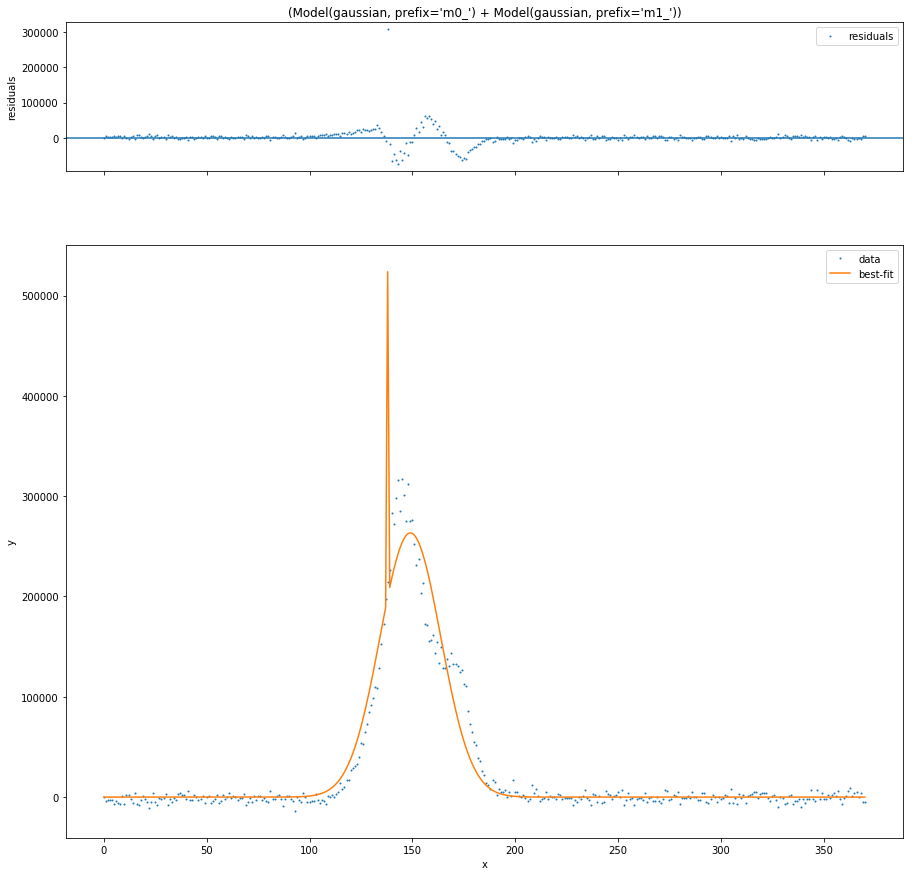

In [43]:
spec = {
    'x': x,
    'y': prof,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'}
    ]
}

mod, params = generate_model(spec)
output = mod.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})


[228]


/home/sara/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


<function matplotlib.pyplot.show(*args, **kw)>

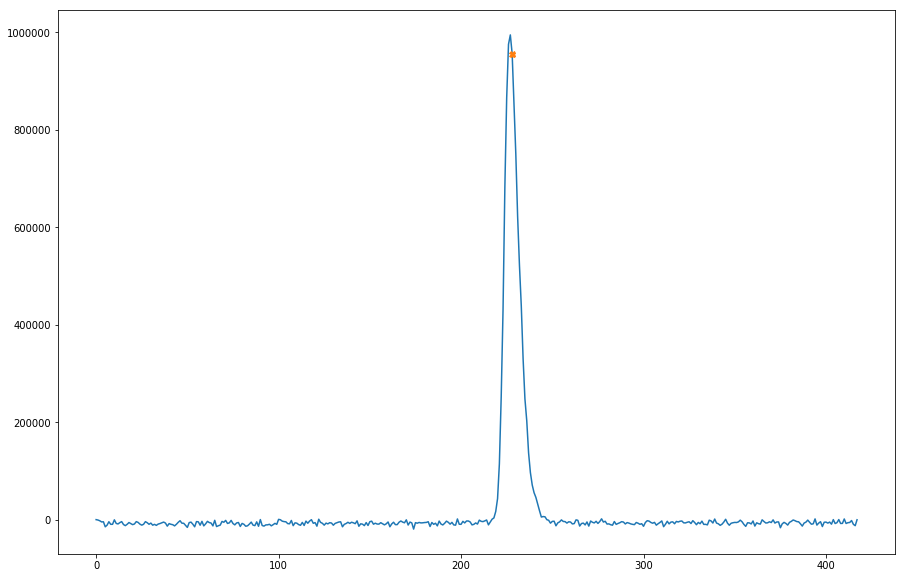

In [44]:
window_y = signal.general_gaussian(3, p=7, sig=1.1)
window_y = signal.fftconvolve(window_y, profy)
peaks_y=signal.find_peaks(window_y,  threshold=80000)
peak_loc_y=list(peaks_y[0])
print(peak_loc_y)
#plt.plot(window_y)
plt.plot(profy)
plt.plot(peak_loc_y, profy[peak_loc_y], marker='X')
plt.show

In [53]:
gauss1 = models.SkewedGaussianModel(prefix='g1_') #SkewedGaussianModel(prefix='g1_')
gauss2= models.SkewedGaussianModel(prefix='g2_')
gauss3= models.SkewedGaussianModel(prefix='g3_')

    
pars = gauss1.guess(prof[100:200], x=x[100:200])

pars.update(gauss2.make_params())

pars.update(gauss3.make_params())

#
#pars['g2_center'].set(295, min=295, max=315)
#pars['g2_sigma'].set(5.6, min=5)
#pars['g2_amplitude'].set(4000000, min=2500000)
#
mod= gauss1 + gauss2 + gauss3
init = mod.eval(pars, x=x)
out  = mod.fit(prof, pars, x=x, weights=np.sqrt(1.0/prof.size))
#print(out.fit_report(min_correl=0.5))

print(out.fit_report())
fig=plt.figure(figsize=(20,12))
plt.plot(x, prof)
#plt.plot(x, out.init_fit, 'k--')
plt.plot(x, out.best_fit, 'r-')
#plt.xlim(250,350)
plt.show()

AttributeError: module 'astropy.modeling.models' has no attribute 'SkewedGaussianModel'

In [55]:
from astropy.modeling import models, fitting

/home/sara/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<function matplotlib.pyplot.show(*args, **kw)>

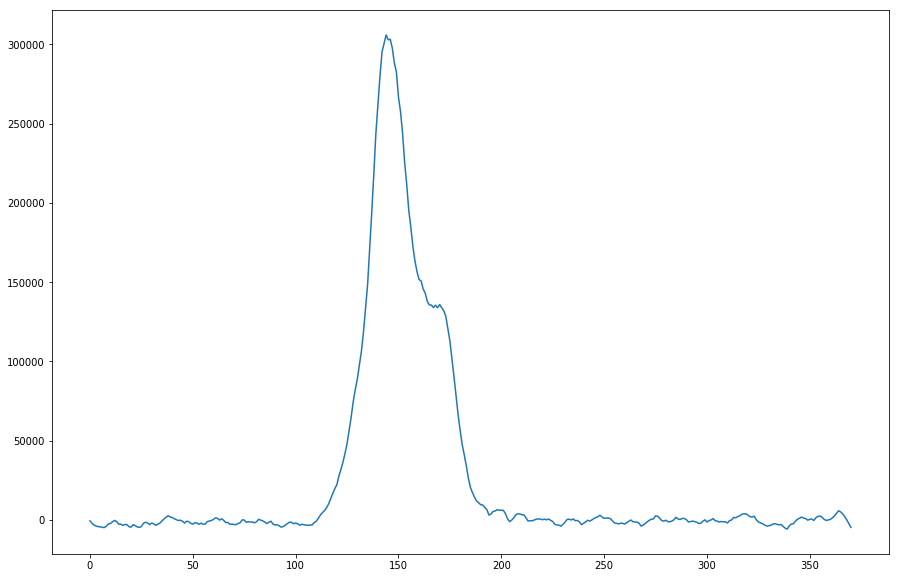

In [47]:
from scipy.signal import savgol_filter
smoothed=savgol_filter(prof, 11, 3)
plt.plot(smoothed)
plt.show


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 944486602029.1259
            Iterations: 3
            Function evaluations: 37
            Gradient evaluations: 3


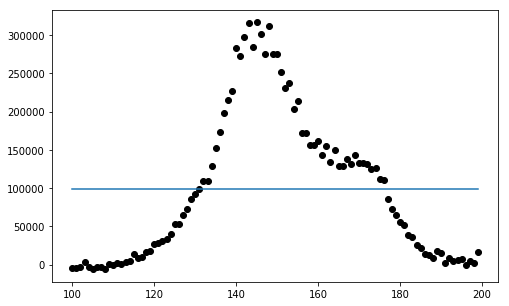

In [48]:

# Now to fit the data create a new superposition with initial
# guesses for the parameters:
gg_init = models.Gaussian1D(30000,145,5) + models.Gaussian1D(15000, 180, 2)

fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, x[100:200], prof[100:200])

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x[100:200], prof[100:200], 'ko')
plt.plot(x[100:200], gg_fit(x[100:200]))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 938743437433.4891
            Iterations: 24
            Function evaluations: 385
            Gradient evaluations: 24


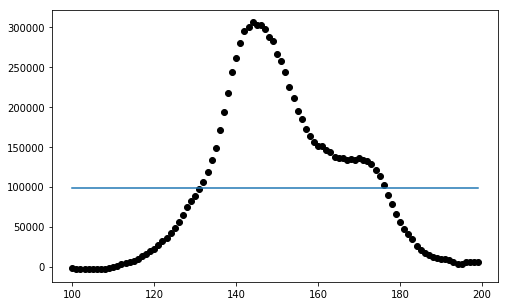

In [49]:

# Now to fit the data create a new superposition with initial
# guesses for the parameters:
gg_init = models.Gaussian1D(30000,145,5) + models.Gaussian1D(15000, 180, 2)

fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, x[100:200], smoothed[100:200])

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x[100:200], smoothed[100:200], 'ko')
plt.plot(x[100:200], gg_fit(x[100:200]))

(array([1.48825093e+02, 1.73499597e+02, 1.44769120e+01, 2.93338611e-01,
       2.66276553e+05, 1.50000000e+05]), 1)


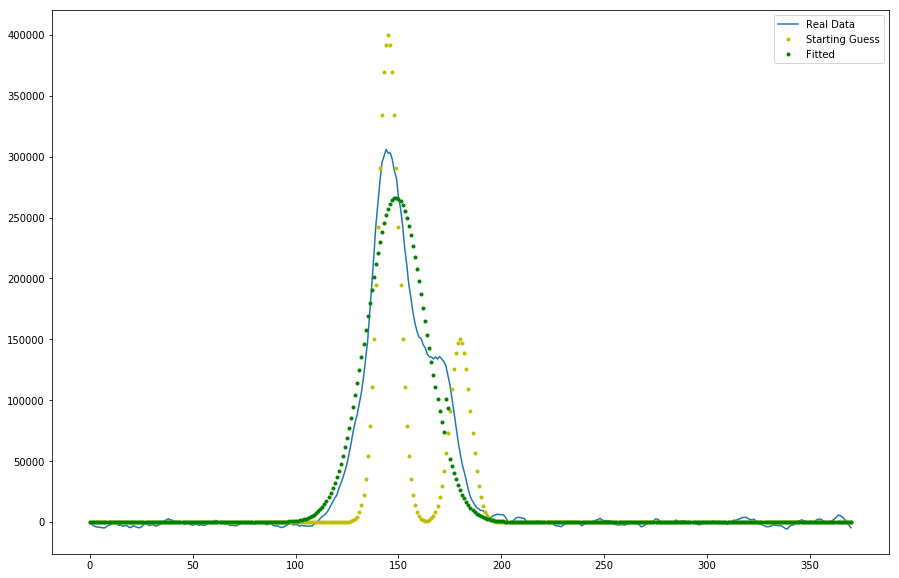

In [50]:
from scipy.optimize import leastsq

######################################
# Setting up test data
def gaussian( x, mean, sd, a):
    res =    a* np.exp( - (x - mean)**2.0 / (2.0 * sd**2.0) )
    return res
#mean1, mean2 = 0, -2
#std1, std2 = 0.5, 1 

#x = np.linspace(-20, 20, 500)
#y_real = norm(x, mean1, std1) + norm(x, mean2, std2)
x=np.arange(371)
y_real=smoothed

######################################
# Solving
m, dm, sd1, sd2, a1, a2= [145, 180, 5, 5, 400000, 150000]
p = [m, dm, sd1, sd2, a1, a2] # Initial guesses for leastsq
y_init = gaussian(x, m, sd1, a1) + gaussian(x, dm, sd2, a2) # For final comparison plot

def res(p, y, x):
  m, dm, sd1, sd2, a1, a2 = p
  m1 = m
  m2 = dm
  a1 = a1
  a2 = a2
  y_fit = gaussian(x, m1, sd1, a1) + gaussian(x, m2, sd2, a1)
  err = y - y_fit
  return err

plsq = leastsq(res, p, args = (y_real, x))
print(plsq) #

y_est = gaussian(x, plsq[0][0], plsq[0][2], plsq[0][4]) + gaussian(x, plsq[0][1], plsq[0][3], plsq[0][5])

plt.plot(x, y_real, label='Real Data')
plt.plot(x, y_init, 'y.', label='Starting Guess')
plt.plot(x, y_est, 'g.', label='Fitted')
plt.legend()
plt.show()

[146]


/home/sara/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


<function matplotlib.pyplot.show(*args, **kw)>

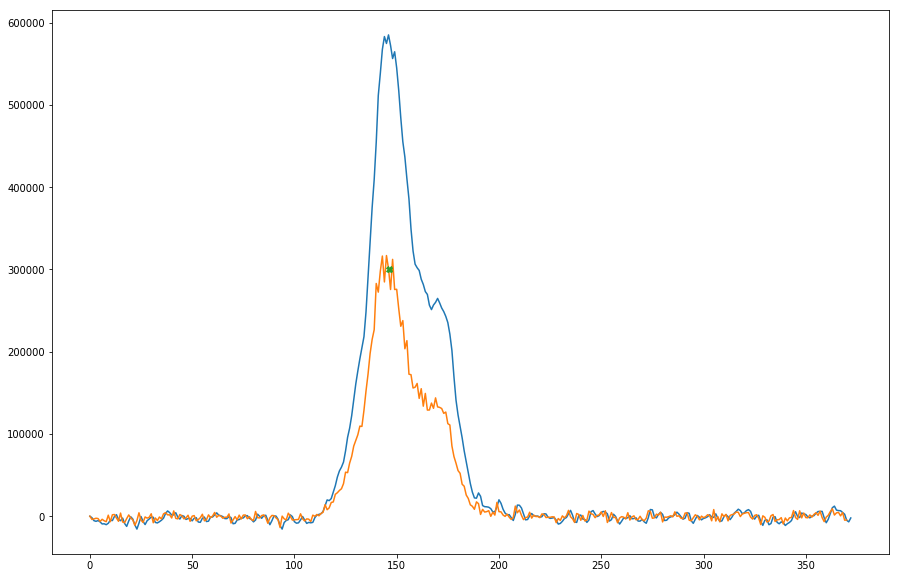

In [51]:
window = signal.general_gaussian(3
                                , p=1
                                 , sig=0.8
                                
                                )
window = signal.fftconvolve(window, prof)
peaks=signal.find_peaks(window,  threshold=10000)
peak_loc=list(peaks[0])
print(peak_loc)
plt.plot(window)
plt.plot(prof)
plt.plot(peak_loc, prof[peak_loc], marker='X')
plt.show

In [52]:
def double_gaussian( x, c1, mu1):
    sigma1=2.6
    sigma2=5.6
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
              + c1*1.18245 * np.exp( - (x - (mu1+4.9))**2.0 / (2.0 * sigma2**2.0) ) 
    return res


gmod = Model(double_gaussian)
result = gmod.fit(prof,x=x, c1=300000, mu1=150)#, weights=np.sqrt(1.0/prof.size))

print(out.fit_report())
fig=plt.figure(figsize=(20,12))

plt.plot(x, prof)
#plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
#plt.plot(x, out.best_fit, 'g-')
#plt.xlim(250,350)
plt.show()

NameError: name 'Model' is not defined